# Prediciting How deep into the tournament a team is expected to go

I wanto to slightly bias angainst eliminiting teams that are expected to make a deep run

By nature of the scoring, if a matchup is 50/50 in the head to hea model, but one team has a chance to win it all while the other team doesn't (I know it's not a common scenario but sometimes a 'bad' team could matchup well against a 'good' team) I want the team that can make a deep run to be selected sligtly more.

To do that, I do need a model that predicts either P(Make the final four) or E[Round of elimination]

Since the target in the second one is categorical, but still very much ordinal, Im not sure if its better to treat it as a regression or a multi-class classification problem.

If I go with option #1 (P(make final Four)), I have to remember that those two classes will be very imbalanced, but there are ways to deal with that.



In [21]:
import os
import pandas as pd
import numpy as np
import sklearn
import random
import time
from sklearn.model_selection import train_test_split


In [3]:
os.chdir('C:\\Users\\Nick\\Python Projects\\2024 March Madness\\MMML')

In [4]:
MTeams = pd.read_csv('Data\\MTeams.csv')
WTeams = pd.read_csv('Data\\WTeams.csv')

MTeamInfo = pd.read_csv('Data\\MTeamInfo.csv')
WTeamInfo = pd.read_csv('Data\\WTeamInfo.csv')

MTourneyResults = pd.read_csv('Data\\MNCAATourneyCompactResults.csv')
WTourneyResults = pd.read_csv('Data\\WNCAATourneyCompactResults.csv')

MTourneySeeds = pd.read_csv('Data\\MNCAATourneySeeds.csv')
WTourneySeeds = pd.read_csv('Data\\WNCAATourneySeeds.csv')

MSlots = pd.read_csv('Data\\MNCAATourneySlots.csv')
WSlots = pd.read_csv('Data\\WNCAATourneySlots.csv')

Start by figuring out how far each team made it in the tourney


In [5]:
MTourneyResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2446,2023,146,1274,88,1400,81,N,0
2447,2023,146,1361,57,1166,56,N,0
2448,2023,152,1163,72,1274,59,N,0
2449,2023,152,1361,72,1194,71,N,0


In [6]:
MTourneySeeds['RoundReached'] = 1
WTourneySeeds['RoundReached'] = 1
MTourneySeeds

,Season,Seed,TeamID,RoundReached
0,1985,W01,1207,1
1,1985,W02,1210,1
2,1985,W03,1228,1
3,1985,W04,1260,1
4,1985,W05,1374,1
...,...,...,...,...
2485,2023,Z12,1433,1
2486,2023,Z13,1233,1
2487,2023,Z14,1213,1
2488,2023,Z15,1421,1


### Finding Mens Rounds reached by team.

Once again I'm going to kind of just brut force this. Its not that much data
Start with mens

In [7]:
MTourneyResults.loc[MTourneyResults.Season == 2021].head(50)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2251,2021,136,1179,53,1455,52,N,0
2252,2021,136,1313,54,1111,53,N,0
2253,2021,136,1411,60,1291,52,N,0
2254,2021,136,1417,86,1277,80,N,1
2255,2021,137,1116,85,1159,68,N,0
2256,2021,137,1124,79,1216,55,N,0
2257,2021,137,1196,75,1439,70,N,1
2258,2021,137,1222,87,1156,56,N,0
2259,2021,137,1228,78,1180,49,N,0
2260,2021,137,1260,71,1210,60,N,0


In [8]:
#Filter out first four games
MTR = MTourneyResults.loc[(MTourneyResults.DayNum >= 137) | ((MTourneyResults.DayNum == 136) & (MTourneyResults.Season != 2021))]
MTR

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2446,2023,146,1274,88,1400,81,N,0
2447,2023,146,1361,57,1166,56,N,0
2448,2023,152,1163,72,1274,59,N,0
2449,2023,152,1361,72,1194,71,N,0


Quick test. I basically want to count how many games each team won. 2023 sdsu won 5 games, and thus made it to round 6

In [9]:
MTR.loc[(MTourneyResults.WTeamID == 1361) & (MTourneyResults.Season == 2023)]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2400,2023,136,1361,63,1158,57,N,0
2424,2023,138,1361,75,1202,52,N,0
2442,2023,144,1361,71,1104,64,N,0
2447,2023,146,1361,57,1166,56,N,0
2449,2023,152,1361,72,1194,71,N,0


This command ruturna a df of 5 rows which is what we want

In [10]:
start_time = time.time()
for i in range(len(MTourneySeeds)):
    team = MTourneySeeds.loc[i, 'TeamID']
    year =  MTourneySeeds.loc[i, 'Season']
    tmp = MTR.loc[(MTourneyResults.WTeamID == team) & (MTourneyResults.Season == year)]
    MTourneySeeds.loc[i, 'RoundReached'] = len(tmp) + 1
    
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 1.7009427547454834 seconds


In [11]:
MTourneySeeds['ReachF4'] = MTourneySeeds['RoundReached'] >= 5

In [12]:
MTourneySeeds['Seed'] = MTourneySeeds['Seed'].str.replace(r'\D+', '', regex=True).astype(int)
MTourneySeeds

,Season,Seed,TeamID,RoundReached,ReachF4
0,1985,1,1207,6,True
1,1985,2,1210,4,False
2,1985,3,1228,3,False
3,1985,4,1260,3,False
4,1985,5,1374,2,False
...,...,...,...,...,...
2485,2023,12,1433,1,False
2486,2023,13,1233,1,False
2487,2023,14,1213,1,False
2488,2023,15,1421,1,False


Now for the final dataset. (for men). Merge the seeding and results data with teamInfo (season stats) Data.


In [14]:
MStats = pd.merge(MTourneySeeds, MTeamInfo, on=['TeamID', 'Season'], how='left')

In [16]:
MStats

,Season,Seed,TeamID,RoundReached,ReachF4,Wins,Losses,Conference,SOS,P_PG,...,OREB_PCT,EFG_PCT,Opp_EFG_PCT,OFF_RTG,DEF_RTG,NET_RTG,TOV_PCT,Ranking1,Ranking2,Ranking3
0,1985,1,1207,6,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,2,1210,4,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985,3,1228,3,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1985,4,1260,3,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1985,5,1374,2,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485,2023,12,1433,1,False,27.0,7.0,a_ten,0.536665,71.441176,...,0.267453,0.522277,0.469795,104.815742,91.347796,1.147436,0.188573,108.0,78.0,58.0
2486,2023,13,1233,1,False,27.0,7.0,maac,0.486824,76.382353,...,0.321723,0.518519,0.459084,110.825666,94.441216,1.173488,0.149361,55.0,83.0,74.0
2487,2023,14,1213,1,False,21.0,11.0,wac,0.511146,72.312500,...,0.279396,0.528990,0.471658,108.234017,102.432659,1.056636,0.170723,110.0,121.0,109.0
2488,2023,15,1421,1,False,25.0,7.0,big_south,0.447760,72.968750,...,0.233475,0.539474,0.479730,105.129036,97.897155,1.073872,0.188647,214.0,181.0,146.0


Unfortunatley I only have game stats from 2003 onward. I will have to drop everything before that

In [19]:
MensData = MStats.loc[MStats.Season >= 2003]
MensData.isna().sum()

Season               0
Seed                 0
TeamID               0
RoundReached         0
ReachF4              0
Wins                 0
Losses               0
Conference           0
SOS                  0
P_PG                 0
PA_PG                0
FGM_PG               0
FGM3_PG              0
OR_PG                0
DR_PG                0
Ast_PG               0
TO_PG                0
Stl_PG               0
Blk_PG               0
PF_PG                0
Opp_FGM_PG           0
Opp_FGM3_PG          0
Opp_OR_PG            0
Opp_DR_PG            0
Opp_Ast_PG           0
Opp_TO_PG            0
Opp_Stl_PG           0
Opp_Blk_PG           0
Opp_PF_PG            0
FG_PCT               0
FG_PCT3              0
FT_PCT               0
Opp_FG_PCT           0
Opp_FG_PCT3          0
Opp_FT_PCT           0
POSS_PER_GAME        0
Opp_POSS_PER_GAME    0
DREB_PCT             0
OREB_PCT             0
EFG_PCT              0
Opp_EFG_PCT          0
OFF_RTG              0
DEF_RTG              0
NET_RTG    

In [24]:
MX = MensData.drop(columns = ['TeamID', 'RoundReached', 'ReachF4'])
My = MensData['RoundReached']

MX_train, MX_test, My_train, My_test = train_test_split(MX, My, test_size=0.2, random_state=123)

# Print the shapes of the train and test sets
print("Shape of X_train:", MX_train.shape)
print("Shape of X_test:", MX_test.shape)
print("Shape of y_train:", My_train.shape)
print("Shape of y_test:", My_test.shape)

Shape of X_train: (1068, 45)
Shape of X_test: (268, 45)
Shape of y_train: (1068,)
Shape of y_test: (268,)


In [50]:
MX_train.columns

Index(['Season', 'Seed', 'Wins', 'Losses', 'Conference', 'SOS', 'P_PG',
       'PA_PG', 'FGM_PG', 'FGM3_PG', 'OR_PG', 'DR_PG', 'Ast_PG', 'TO_PG',
       'Stl_PG', 'Blk_PG', 'PF_PG', 'Opp_FGM_PG', 'Opp_FGM3_PG', 'Opp_OR_PG',
       'Opp_DR_PG', 'Opp_Ast_PG', 'Opp_TO_PG', 'Opp_Stl_PG', 'Opp_Blk_PG',
       'Opp_PF_PG', 'FG_PCT', 'FG_PCT3', 'FT_PCT', 'Opp_FG_PCT', 'Opp_FG_PCT3',
       'Opp_FT_PCT', 'POSS_PER_GAME', 'Opp_POSS_PER_GAME', 'DREB_PCT',
       'OREB_PCT', 'EFG_PCT', 'Opp_EFG_PCT', 'OFF_RTG', 'DEF_RTG', 'NET_RTG',
       'TOV_PCT', 'Ranking1', 'Ranking2', 'Ranking3'],
      dtype='object')

### Random Forest

Starting with a random forest so i dont have to scale data for it yet

In [29]:
numeric_features = ['Season', 'Seed', 'Wins', 'Losses', 'SOS', 'P_PG',
       'PA_PG', 'FGM_PG', 'FGM3_PG', 'OR_PG', 'DR_PG', 'Ast_PG', 'TO_PG',
       'Stl_PG', 'Blk_PG', 'PF_PG', 'Opp_FGM_PG', 'Opp_FGM3_PG', 'Opp_OR_PG',
       'Opp_DR_PG', 'Opp_Ast_PG', 'Opp_TO_PG', 'Opp_Stl_PG', 'Opp_Blk_PG',
       'Opp_PF_PG', 'FG_PCT', 'FG_PCT3', 'FT_PCT', 'Opp_FG_PCT', 'Opp_FG_PCT3',
       'Opp_FT_PCT', 'POSS_PER_GAME', 'Opp_POSS_PER_GAME', 'DREB_PCT',
       'OREB_PCT', 'EFG_PCT', 'Opp_EFG_PCT', 'OFF_RTG', 'DEF_RTG', 'NET_RTG',
       'TOV_PCT', 'Ranking1', 'Ranking2', 'Ranking3']

categorical_features = ['Conference']

In [54]:
#Import libraries

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [55]:
#Create Pipeline

preprocessor = make_column_transformer((StandardScaler(),numeric_features), 
                               (TargetEncoder(),categorical_features))

pipe = make_pipeline(preprocessor, RandomForestRegressor())

In [56]:
scores = cross_val_score(pipe, MX_train, My_train)

In [57]:
scores


array([0.34773358, 0.29846411, 0.38541275, 0.12349282, 0.40612313])

In [59]:
pipe.fit(MX_train, My_train)

y_pred = pipe.predict(MX_test)

In [67]:
mpreds = pd.DataFrame(My_test)
mpreds['pred'] = y_pred
mpreds['diff'] = mpreds['RoundReached']-mpreds['pred']
mpreds.sort_values('diff')

,RoundReached,pred,diff
2082,2,4.96,-2.96
2440,1,3.24,-2.24
1220,2,3.91,-1.91
1235,2,3.86,-1.86
2371,3,4.83,-1.83
...,...,...,...
1696,4,2.05,1.95
1332,7,4.55,2.45
1505,4,1.53,2.47
2238,6,2.92,3.08


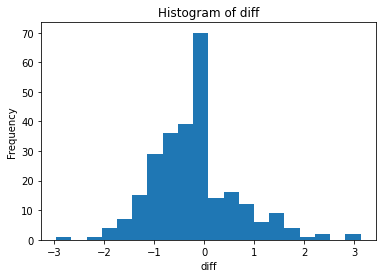

In [71]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to plot
column_name = 'diff'

# Plot histogram
plt.hist(mpreds[column_name], bins=20)  # Adjust the number of bins as needed
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)
plt.show()

In [72]:
MStats.iloc[2082]

Season                     2017
Seed                          1
TeamID                     1437
RoundReached                  2
ReachF4                   False
Wins                       31.0
Losses                      3.0
Conference             big_east
SOS                    0.562091
P_PG                  77.676471
PA_PG                 62.794118
FGM_PG                26.852941
FGM3_PG                8.823529
OR_PG                  8.558824
DR_PG                 24.794118
Ast_PG                14.294118
TO_PG                 11.205882
Stl_PG                 7.235294
Blk_PG                 3.088235
PF_PG                 14.205882
Opp_FGM_PG                 23.5
Opp_FGM3_PG            7.058824
Opp_OR_PG              9.441176
Opp_DR_PG             20.323529
Opp_Ast_PG            13.588235
Opp_TO_PG             13.294118
Opp_Stl_PG             5.147059
Opp_Blk_PG             1.852941
Opp_PF_PG             18.352941
FG_PCT                 0.497006
FG_PCT3                 0.37037
FT_PCT  